In [ ]:
!pip install lightning

In [ ]:
import os
import random
from pathlib import Path
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision.utils import make_grid

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
TRAIN_SKETCH_PATH = "/content/drive/MyDrive/gan_dataset/Train/Train_sketch/Contours"
TRAIN_DATA_PATH = "/content/drive/MyDrive/gan_dataset/Train/Train_data"
TRAIN_DATA_CSV_PATH = "/content/drive/MyDrive/gan_dataset/Train/Train_labels.csv"

In [ ]:
TEST_SKETCH_PATH = "/content/drive/MyDrive/gan_dataset/Test/Test_sketch/Test_contours"
TEST_DATA_PATH = "/content/drive/MyDrive/gan_dataset/Test/Test_data/Test"
TEST_DATA_CSV_PATH = "/content/drive/MyDrive/gan_dataset/Test/Test_Labels.csv"

In [ ]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
SKETCH_WIDTH = 128
SKETCH_HEIGHT = 128
BATCH_SIZE = 128
NUM_WORKERS = 2

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, img_path, sketch_path, csv_data_frame_path, transform_img=None, transform_sketch=None):
    self.img_dir = img_path
    self.sketch_dir = sketch_path
    self.data_frame = pd.read_csv(csv_data_frame_path)
    self.transform_img = transform_img
    self.transform_sketch = transform_sketch
    self.sketch_images = os.listdir(sketch_path)

  def __len__(self):
    return len(self.data_frame)

  def __getitem__(self, idx):
    img_name = os.path.join(self.img_dir, self.data_frame.iloc[idx, 0])
    img = Image.open(img_name + '.jpg').convert('RGB')
    label = torch.tensor(self.data_frame.iloc[idx, 1:], dtype=torch.float32)

    random_index = random.randint(0, len(self.sketch_images) - 1)
    sketch_name = self.sketch_images[random_index]
    sketch_img = Image.open(self.sketch_dir + '/' + sketch_name).convert('RGB')

    if self.transform_img:
      img = self.transform_img(img)

    if self.transform_sketch:
      sketch_img = self.transform_sketch(sketch_img)

    return img, label, sketch_img

In [ ]:
class CustomDataLoader:
  def __init__(self):
    pass

  def setup(self):
    transform_img = transforms.Compose([
        transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    transform_sketch = transforms.Compose([
        transforms.Resize((SKETCH_WIDTH, SKETCH_HEIGHT)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    self.train_dataset = CustomDataset(TRAIN_DATA_PATH, TRAIN_SKETCH_PATH, TRAIN_DATA_CSV_PATH, transform_img, transform_sketch)
    self.test_dataset = CustomDataset(TEST_DATA_PATH, TEST_SKETCH_PATH, TEST_DATA_CSV_PATH, transform_img, transform_sketch)

  def train_dataloader(self):
    return DataLoader(self.train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

  def test_dataloader(self):
    return DataLoader(self.test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [ ]:
data_loader = CustomDataLoader()
data_loader.setup()

In [ ]:
x = iter(data_loader.train_dataloader())

In [ ]:
for i, j, k in x:
  print(k.shape)
  break

torch.Size([32, 1, 128, 128])


In [ ]:
sample_images, sample_masks, y = next(iter(data_loader.train_dataloader()))

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [ ]:
print(sample_images.shape, sample_masks.shape, y.shape)

torch.Size([128, 3, 128, 128]) torch.Size([128, 7]) torch.Size([128, 3, 128, 128])


In [ ]:
print(sample_images[1].shape, sample_masks[1].shape, y[1].shape)

torch.Size([3, 128, 128]) torch.Size([7]) torch.Size([3, 128, 128])


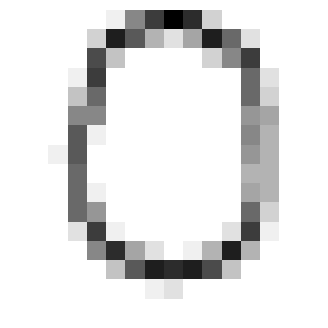

In [ ]:
pil_image = transforms.functional.to_pil_image(y[25])

  # if pil_image.mode == 'L':
  #     pil_image = pil_image.convert('L')

plt.figure(figsize=(4, 4))
plt.imshow(pil_image, cmap='gray')
# plt.title('Sample Image')
plt.axis('off')
plt.show()

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [ ]:
class Discriminator(torch.nn.Module):
    def __init__(self, image_channel=10, hidden_dim=8):
        super(Discriminator, self).__init__()
        self.disc = torch.nn.Sequential(
            self._discriminator_block(image_channel, hidden_dim),
            self._discriminator_block(hidden_dim, hidden_dim * 2),
            self._discriminator_block(hidden_dim*2, hidden_dim * 4),
            self._discriminator_block(hidden_dim*4, hidden_dim * 5),
            self._discriminator_block(hidden_dim*5, hidden_dim * 6),
            self._discriminator_block(hidden_dim * 6, 1, final_layer=True),
        )

    def _discriminator_block(
        self,
        input_channels,
        output_channels,
        kernel_size=4,
        stride=2,
        final_layer=False,
    ):

        if not final_layer:
            return torch.nn.Sequential(
                torch.nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                torch.nn.BatchNorm2d(output_channels),
                torch.nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return torch.nn.Sequential(
                torch.nn.Conv2d(input_channels, output_channels, kernel_size=2, stride=2),
            )

    def forward(self, x):
        # disc_pred = self.disc(image)
        for layer in self.disc:
          # print(x.shape)
          x = layer(x)
        # print(x.shape)
        x = x.view(len(x), -1)
        # print(x.shape)
        return x

In [ ]:
d = Discriminator().to(device)
d

Discriminator(
  (disc): Sequential(
    (0): Sequential(
      (0): Conv2d(10, 8, kernel_size=(4, 4), stride=(2, 2))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(32, 40, kernel_size=(4, 4), stride=(2, 2))
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (4): Sequential(
      (0)

In [ ]:
img_from_gen = torch.randn(32, 10, 128, 128)
d(img_from_gen)

torch.Size([32, 10, 128, 128])
torch.Size([32, 8, 63, 63])
torch.Size([32, 16, 30, 30])
torch.Size([32, 32, 14, 14])
torch.Size([32, 40, 6, 6])
torch.Size([32, 48, 2, 2])
torch.Size([32, 1, 1, 1])
torch.Size([32, 1])


tensor([[ 0.6962],
        [-0.0223],
        [ 0.5972],
        [ 0.4404],
        [ 0.1674],
        [ 0.0712],
        [ 0.1884],
        [ 0.2628],
        [ 0.2154],
        [-0.4105],
        [ 0.1314],
        [ 0.1386],
        [ 1.3398],
        [ 0.1170],
        [ 0.8446],
        [ 0.4955],
        [ 0.1833],
        [-0.5513],
        [ 0.3396],
        [ 0.1114],
        [ 0.2159],
        [ 0.0258],
        [ 0.4841],
        [ 0.4814],
        [ 0.4824],
        [-0.0945],
        [-0.2664],
        [ 0.0854],
        [-0.2011],
        [-0.0612],
        [ 0.1177],
        [ 1.0823]], grad_fn=<ViewBackward0>)

In [ ]:
class Generator(torch.nn.Module):
    def __init__(self, input_dim=263, image_channel=3, hidden_dim=8):
        super(Generator, self).__init__()
        self.input_dim = input_dim

        self.gen = torch.nn.Sequential(
            self._generator_block(input_dim, hidden_dim * 16, kernel_size=4,stride=1, padding=0),
            self._generator_block(hidden_dim * 16, hidden_dim * 8, kernel_size=4,stride=2, padding=1),
            self._generator_block(hidden_dim * 8, hidden_dim*4, kernel_size=4,stride=2, padding=1),
            self._generator_block(hidden_dim * 4, hidden_dim*2, kernel_size=4,stride=2, padding=1),
            self._generator_block(hidden_dim * 2, hidden_dim, kernel_size=4,stride=2, padding=1),
            self._generator_block(
                hidden_dim, image_channel, kernel_size=4, final_layer=True
            ),
        )

    def _generator_block(
        self,
        input_channels,
        output_channels,
        kernel_size=4,
        stride=2,
        padding=1,
        final_layer=False,
    ):
        if not final_layer:
            return torch.nn.Sequential(
                torch.nn.ConvTranspose2d(
                    input_channels, output_channels, kernel_size, stride
                ),
                torch.nn.BatchNorm2d(output_channels),
                torch.nn.ReLU(inplace=True),
            )
        else:
            return torch.nn.Sequential(
                torch.nn.ConvTranspose2d(
                    input_channels, output_channels, kernel_size=35, stride=1
                ),
                torch.nn.Tanh(),
            )

    def forward(self, x):
        # x = noise.view(len(noise), self.input_dim, 1, 1)
        for layer in self.gen:
          # print("1", x.shape)
          x = layer(x)
        # print(x.shape)
        return x

In [ ]:
g = Generator().to(device)
g

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(263, 128, kernel_size=(4, 4), stride=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Sequential(
      (0): ConvTranspose2d(16, 8, kernel_size=(4, 4), stride=(2, 2))
  

In [ ]:
latent = torch.randn(32, 263, 1, 1)
g(latent)

1 torch.Size([32, 263, 1, 1])
1 torch.Size([32, 128, 4, 4])
1 torch.Size([32, 64, 10, 10])
1 torch.Size([32, 32, 22, 22])
1 torch.Size([32, 16, 46, 46])
1 torch.Size([32, 8, 94, 94])
torch.Size([32, 3, 128, 128])


tensor([[[[ 1.5326e-04,  1.7188e-02,  1.6337e-02,  ..., -1.6453e-02,
           -1.1367e-02, -1.3577e-02],
          [ 6.4480e-03,  1.9207e-02,  1.3894e-02,  ..., -1.2024e-02,
           -5.9484e-03, -1.4234e-02],
          [-9.2648e-03,  8.9335e-03, -1.5944e-02,  ...,  2.0695e-02,
           -9.8832e-03, -7.2132e-03],
          ...,
          [ 1.0198e-02,  4.9286e-03, -8.6900e-04,  ...,  7.6106e-03,
           -1.8816e-02, -8.2614e-03],
          [-2.7399e-03, -6.4535e-03, -3.5522e-03,  ...,  7.8226e-03,
           -1.0567e-02, -1.2713e-02],
          [-1.7050e-02, -2.3353e-02, -2.9245e-02,  ..., -1.1667e-03,
            3.5362e-03,  3.1572e-03]],

         [[ 6.2230e-03,  6.8392e-05, -7.5744e-03,  ...,  6.9993e-04,
            5.3984e-03,  2.1056e-04],
          [ 2.0216e-02,  9.9605e-03,  1.9047e-02,  ..., -2.2978e-02,
           -1.5006e-02, -1.4387e-02],
          [-9.9370e-04,  2.0284e-02, -1.4077e-02,  ...,  9.2296e-03,
            3.1142e-03, -1.0830e-02],
          ...,
     

In [ ]:
criterion = torch.nn.BCEWithLogitsLoss()
n_epochs = 5
display_step = 500
lr = 0.0002

In [ ]:
device

'cuda:0'

In [ ]:
gen_opt = torch.optim.Adam(g.parameters(), lr=lr)

In [ ]:
disc_opt = torch.optim.Adam(d.parameters(), lr=lr)

In [ ]:
def weights_init(m):
    if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, torch.nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

In [ ]:
gen = g.apply(weights_init)

disc = d.apply(weights_init)

In [ ]:
cur_step = 0
generator_losses = []
discriminator_losses = []

noise_and_labels = False
fake = False

fake_image_and_labels = False
real_image_and_labels = False
disc_fake_pred = False
disc_real_pred = False

In [ ]:
train_data_loader = data_loader.train_dataloader()

In [ ]:
def plot_images_from_tensor(image_tensor, num_images=25, size=(1, 28, 28), nrow=5, show=True):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    if show:
        plt.show()


  0%|          | 1/313 [00:47<4:08:31, 47.79s/it]

Let Long Training Continue


 60%|█████▉    | 187/313 [05:00<04:04,  1.94s/it]

Step 500: Generator loss: 1.114204119682312, discriminator loss: 0.49172431880235673


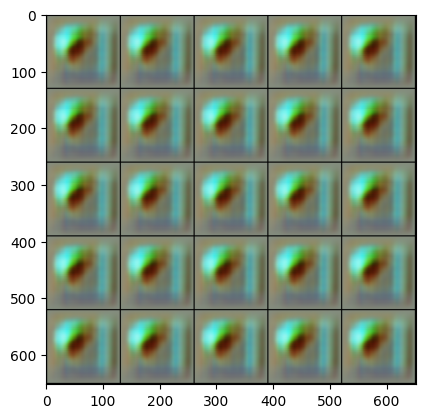

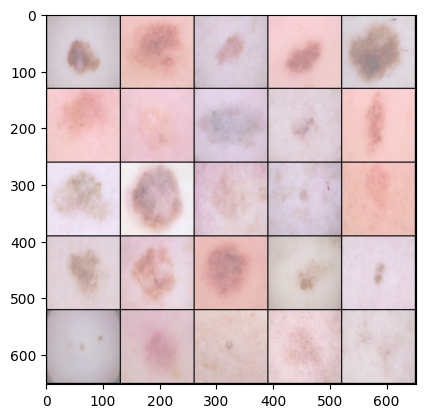

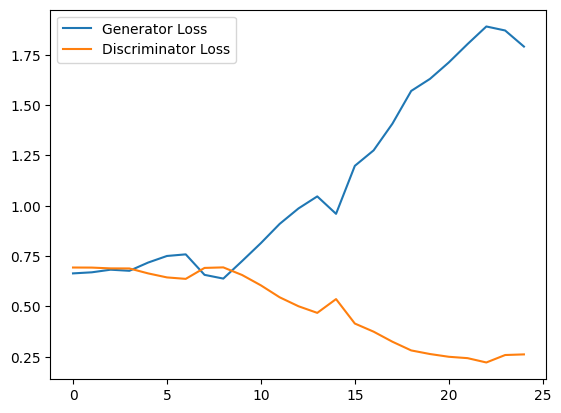

 19%|█▉        | 61/313 [01:43<05:50,  1.39s/it]

Step 1000: Generator loss: 2.412810505270958, discriminator loss: 0.20453201167285442


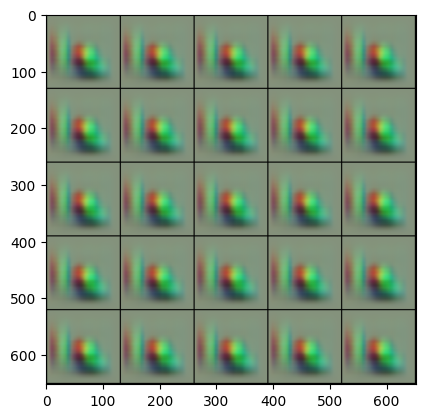

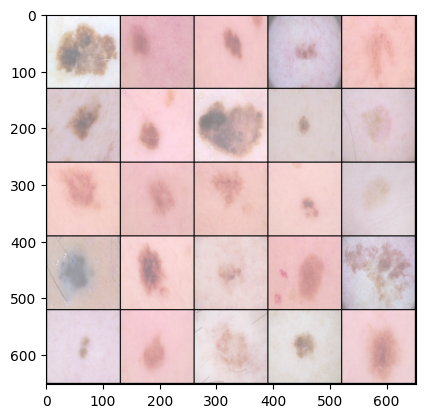

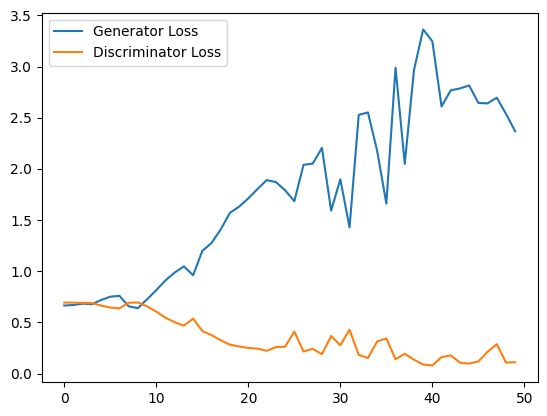

 79%|███████▉  | 248/313 [06:59<01:59,  1.84s/it]

Step 1500: Generator loss: 3.1675209102630615, discriminator loss: 0.11276492991670967


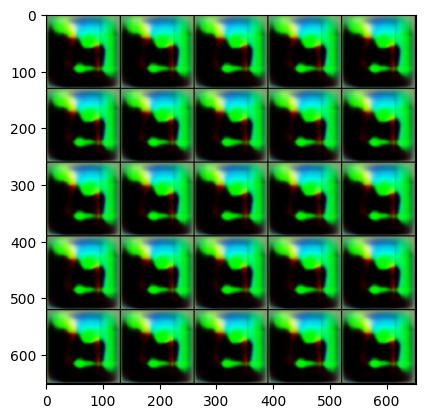

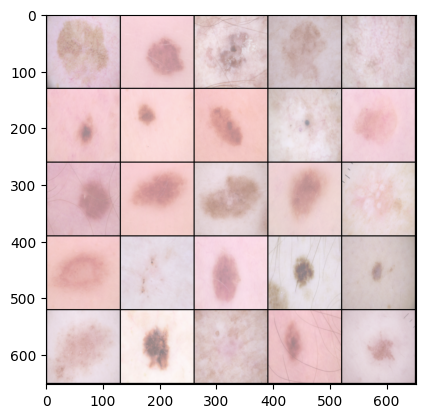

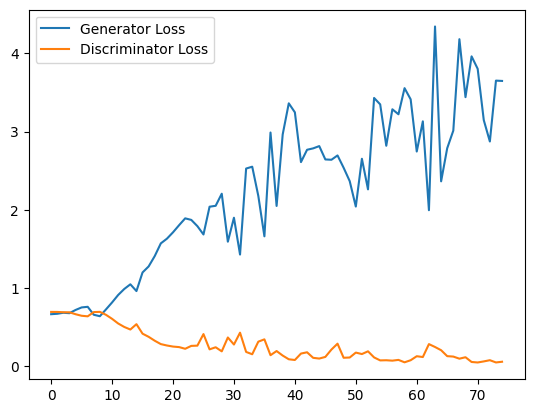

100%|██████████| 313/313 [08:45<00:00,  1.68s/it]


In [ ]:
for epoch in range(n_epochs):
    for real, labels, latent in tqdm(train_data_loader):
        cur_batch_size = len(real)
        real = real.to(device)
        # print(real.shape, labels.shape, latent.shape)
        image_one_hot_labels = labels.unsqueeze(-1).unsqueeze(-1).expand(-1, -1, 16, 16)
        # print(real.shape, image_one_hot_labels.shape, latent.shape)
        disc_opt.zero_grad()

        flattened_tensor = latent.view(latent.size(0), -1, 1, 1)
        # print("f", flattened_tensor.shape)
        reshaped_tensor = labels.view(labels.size(0), labels.size(1), 1, 1)
        # print("g", reshaped_tensor.shape, )
        noise_and_labels = torch.cat((flattened_tensor.float(), reshaped_tensor.float()), 1).to(device)
        # print(noise_and_labels.shape)
        fake = gen(noise_and_labels).to(device)
        # print(fake.shape, "h")

        zeros_dim = torch.zeros(labels.shape[0], labels.shape[1], 128, 128)
        # print("z", zeros_dim.shape)
        labels = labels.unsqueeze(-1).unsqueeze(-1)
        # print("l", labels.shape)
        upscaled_tensor = torch.nn.functional.interpolate(labels, size=(128, 128), mode='nearest')
        upscaled_tensor = upscaled_tensor.to(device)
        # print("l2", upscaled_tensor.shape)
        # reshaped_tensor = torch.cat((labels, zeros_dim), dim=-1)
        # print("l1", reshaped_tensor.shape)
        # fake_image_and_labels = concat_vectors(fake, image_one_hot_labels)
        fake_image_and_labels =  torch.cat((fake.float(), upscaled_tensor.float()), 1).to(device)
        # print("m, ", fake_image_and_labels.shape)

        real_image_and_labels = torch.cat((real.float(), upscaled_tensor.float()), 1).to(device)

        disc_fake_pred = disc(fake_image_and_labels.detach()).to(device)
        disc_real_pred = disc(real_image_and_labels).to(device)

        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))

        disc_loss = (disc_fake_loss + disc_real_loss) / 2

        disc_loss.backward(retain_graph=True)
        disc_opt.step()

        discriminator_losses += [disc_loss.item()]

        gen_opt.zero_grad()

        fake_image_and_labels = torch.cat((fake.float(), upscaled_tensor.float()), 1)
        disc_fake_pred = disc(fake_image_and_labels)


        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))

        gen_loss.backward()
        gen_opt.step()

        generator_losses += [gen_loss.item()]


        if cur_step % display_step == 0 and cur_step > 0:

            gen_mean = sum(generator_losses[-display_step:]) / display_step

            disc_mean = sum(discriminator_losses[-display_step:]) / display_step
            print(
                f"Step {cur_step}: Generator loss: {gen_mean}, discriminator loss: {disc_mean}"
            )

            plot_images_from_tensor(fake)
            plot_images_from_tensor(real)

            step_bins = 20
            x_axis = sorted(
                [i * step_bins for i in range(len(generator_losses) // step_bins)]
                * step_bins
            )
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins),
                torch.Tensor(generator_losses[:num_examples])
                .view(-1, step_bins)
                .mean(1),
                label="Generator Loss",
            )
            plt.plot(
                range(num_examples // step_bins),
                torch.Tensor(discriminator_losses[:num_examples])
                .view(-1, step_bins)
                .mean(1),
                label="Discriminator Loss",
            )
            plt.legend()
            plt.show()
        elif cur_step == 0:
            print("Let Long Training Continue")
        cur_step += 1